In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import sys

sys.path.append("/home/dchen/BA_CH_EN/")

# Basics
import tensorflow as tf
import xarray as xr

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores
from src.models.U_net.unet import Unet

2023-06-30 16:58:01.108702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/lib/
2023-06-30 16:58:01.108723: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<IPython.core.display.Javascript object>

### 0. Setup

In [3]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping


class CustomEarlyStopping(Callback):
    def __init__(self, patience=5):
        super(CustomEarlyStopping, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf
        self.early_stopping = EarlyStopping(patience=self.patience)

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get("loss")
        if current_loss is None:
            return

        if current_loss < 1:
            if np.less(current_loss, self.best):
                self.best = current_loss
                self.wait = 0
                # Record the best weights if current results is better (less).
                self.best_weights = self.model.get_weights()
            else:
                self.wait += 1
                if self.wait >= self.patience:
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                    print("Restoring model weights from the end of the best epoch.")
                    self.model.set_weights(self.best_weights)
        else:
            # If loss is greater than 1, then reset the patience and best score
            self.wait = 0
            self.best = np.Inf

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

<IPython.core.display.Javascript object>

### 1. Load Data

In [4]:
# Denormed Processed Data
dat_train_denorm = ldpd.load_data_all_train_proc_denorm()
dat_test_denorm = ldpd.load_data_all_test_proc_denorm()

<IPython.core.display.Javascript object>

### 2. Data Split

In [5]:
dat_X_train_lead_all_denorm, dat_y_train_lead_all_denorm = split_var_lead(
    dat_train_denorm
)
dat_X_test_lead_all_denorm, dat_y_test_lead_all_denorm = split_var_lead(dat_test_denorm)

<IPython.core.display.Javascript object>

### 3. Building U-Net

Test with t2m lead_time = 6h

In [6]:
train_data_mean = dat_X_train_lead_all_denorm[2][0].isel(mean_std=0)
train_data_std = dat_X_train_lead_all_denorm[2][0].isel(mean_std=1)
train_data_y = dat_y_train_lead_all_denorm[2][0]
train_data_mean = np.expand_dims(train_data_mean, axis=-1)
train_data_std = np.expand_dims(train_data_std, axis=-1)


test_data_mean = dat_X_test_lead_all_denorm[2][0].isel(mean_std=0)
test_data_std = dat_X_test_lead_all_denorm[2][0].isel(mean_std=1)
test_data_y = dat_y_test_lead_all_denorm[2][0]
test_data_mean = np.expand_dims(test_data_mean, axis=-1)
test_data_std = np.expand_dims(test_data_std, axis=-1)

<IPython.core.display.Javascript object>

In [11]:
def pad_images(images, desired_shape=(128, 144)):
    padded_images = np.pad(
        images,
        (
            (0, 0),  # don't pad along the batch axis
            (
                (desired_shape[0] - images.shape[1]) // 2,
                (desired_shape[0] - images.shape[1]) // 2,
            ),  # pad symmetrically along the height
            (
                (desired_shape[1] - images.shape[2]) // 2,
                (desired_shape[1] - images.shape[2]) // 2,
            ),  # pad symmetrically along the width
            (0, 0),
        ),  # don't pad along the channel axis
        mode="reflect",
    )
    return padded_images


def pad_images_y(images, desired_shape=(128, 144)):
    # Calculate padding for height and width
    pad_height = desired_shape[0] - images.shape[1]
    pad_width = desired_shape[1] - images.shape[2]

    # Distribute padding evenly to both sides, add extra to the end if odd difference
    pad_height_t, pad_height_b = pad_height // 2, pad_height - pad_height // 2
    pad_width_l, pad_width_r = pad_width // 2, pad_width - pad_width // 2

    padded_images = np.pad(
        images,
        (
            (0, 0),  # don't pad along the batch axis
            (pad_height_t, pad_height_b),  # pad symmetrically along the height
            (pad_width_l, pad_width_r),  # pad symmetrically along the width
        ),
        mode="reflect",
    )

    return padded_images

<IPython.core.display.Javascript object>

In [12]:
# pad your train and test datasets
padded_train_data_mean = pad_images(train_data_mean)
padded_train_data_std = pad_images(train_data_std)
padded_train_data_y = pad_images_y(train_data_y)
# padded_test_data = pad_images(test_data)
padded_test_data_mean = pad_images(test_data_mean)
padded_test_data_std = pad_images(test_data_std)
padded_test_data_y = pad_images_y(test_data_y)


print(padded_train_data_mean.shape)
print(padded_train_data_y.shape)  # should print (1429, 128, 136, 1)

print(padded_test_data_mean.shape)
print(padded_test_data_y.shape)
# print(padded_test_data.shape) # should print (357, 128, 136, 1)

(1429, 128, 144, 1)
(1429, 128, 144)
(357, 128, 144, 1)
(357, 128, 144)


<IPython.core.display.Javascript object>

In [13]:
# Parameters for Unet class initialization
v = "tp"  # Or any other value based on your preference
train_patches = False  # Or True if you want to train with patches

# Initialize the U-Net model
unet_model = Unet(v=v, train_patches=train_patches)

# Build the model with your training data shape
model = unet_model.build_model(padded_train_data_mean.shape, 2, learning_rate=0.01)

Downsampling block 1 shape:  (None, 64, 72, 16)
Downsampling block 2 shape:  (None, 32, 36, 32)
Downsampling block 3 shape:  (None, 16, 18, 64)
Downsampling block 4 shape:  (None, 8, 9, 128)
Bottleneck shape:  (None, 8, 9, 256)
Upsampling block 5 shape:  (None, 8, 9, 256)
Upsampling block 4 shape:  (None, 16, 18, 128)
Upsampling block 3 shape:  (None, 32, 36, 64)
Upsampling block 2 shape:  (None, 64, 72, 32)
Upsampling block 1 shape:  (None, 128, 144, 16)


<IPython.core.display.Javascript object>

In [14]:
hist = model.fit(
    [padded_train_data_mean, padded_train_data_std],
    padded_train_data_y,
    epochs=150,
    shuffle=False,
    batch_size=64,
    validation_split=0.25,
    callbacks=[CustomEarlyStopping()],
)

Epoch 1/150
Var equals 0
Var equals 0
17/17 [==============================] - 39s 2s/step - loss: 282.4002 - val_loss: 3223.5952
Epoch 2/150
17/17 [==============================] - 36s 2s/step - loss: 278.9710 - val_loss: 194.5182
Epoch 3/150
17/17 [==============================] - 36s 2s/step - loss: 273.7575 - val_loss: 274.1623
Epoch 4/150
17/17 [==============================] - 36s 2s/step - loss: 266.2137 - val_loss: 260.9144
Epoch 5/150
17/17 [==============================] - 36s 2s/step - loss: 256.0218 - val_loss: 239.0326
Epoch 6/150
17/17 [==============================] - 35s 2s/step - loss: 242.9891 - val_loss: 237.6014
Epoch 7/150
17/17 [==============================] - 36s 2s/step - loss: 227.0119 - val_loss: 208.1867
Epoch 8/150
17/17 [==============================] - 35s 2s/step - loss: 208.0249 - val_loss: 1104.3668
Epoch 9/150
17/17 [==============================] - 36s 2s/step - loss: 185.9719 - val_loss: 106.1190
Epoch 10/150
17/17 [=========================

17/17 [==============================] - 35s 2s/step - loss: 2.6269 - val_loss: 10.7429
Epoch 81/150
17/17 [==============================] - 35s 2s/step - loss: 2.6277 - val_loss: 17.6757
Epoch 82/150
17/17 [==============================] - 36s 2s/step - loss: 2.5833 - val_loss: 15.2596
Epoch 83/150
17/17 [==============================] - 35s 2s/step - loss: 2.5780 - val_loss: 17.0953
Epoch 84/150
17/17 [==============================] - 35s 2s/step - loss: 2.5448 - val_loss: 10.9863
Epoch 85/150
17/17 [==============================] - 35s 2s/step - loss: 2.4945 - val_loss: 8.2029
Epoch 86/150
17/17 [==============================] - 35s 2s/step - loss: 2.4822 - val_loss: 5.1114
Epoch 87/150
17/17 [==============================] - 35s 2s/step - loss: 2.4663 - val_loss: 10.1120
Epoch 88/150
17/17 [==============================] - 35s 2s/step - loss: 2.4529 - val_loss: 3.4284
Epoch 89/150
17/17 [==============================] - 35s 2s/step - loss: 2.4376 - val_loss: 6.2105
Epoch 9

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

### 3. Model Predict

In [15]:
train_preds = model.predict([padded_train_data_mean, padded_train_data_std], verbose=1)
test_preds = model.predict([padded_test_data_mean, padded_test_data_std], verbose=1)

12/12 [==============================] - 1s 118ms/step


<IPython.core.display.Javascript object>

In [16]:
def unpad_images(images, original_shape=(120, 130)):
    # Calculate padding for height and width
    pad_height = (images.shape[1] - original_shape[0]) // 2
    pad_width = (images.shape[2] - original_shape[1]) // 2

    unpadded_images = images[
        :, pad_height : -pad_height or None, pad_width : -pad_width or None, :
    ]
    return unpadded_images


def unpad_images_y(images, original_shape=(120, 130)):
    # Calculate padding for height and width
    pad_height_t = (images.shape[1] - original_shape[0]) // 2
    pad_height_b = images.shape[1] - pad_height_t - original_shape[0]

    pad_width_l = (images.shape[2] - original_shape[1]) // 2
    pad_width_r = images.shape[2] - pad_width_l - original_shape[1]

    unpadded_images = images[
        :, pad_height_t : -pad_height_b or None, pad_width_l : -pad_width_r or None
    ]
    return unpadded_images

<IPython.core.display.Javascript object>

In [17]:
train_preds_unpad = unpad_images(train_preds)
test_preds_unpad = unpad_images(test_preds)
unpadded_test_data_y = unpad_images_y(padded_test_data_y)

<IPython.core.display.Javascript object>

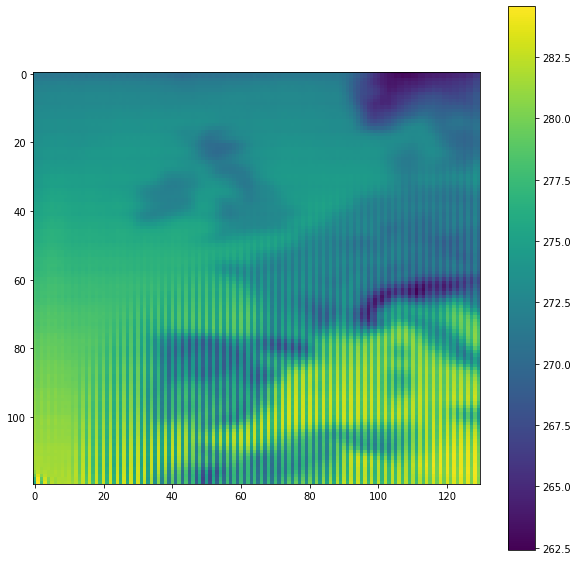

<IPython.core.display.Javascript object>

In [18]:
plt.figure(figsize=(10, 10))
plt.imshow(np.mean(test_preds_unpad[:, :, :, 0], axis=0))
cbar = plt.colorbar()

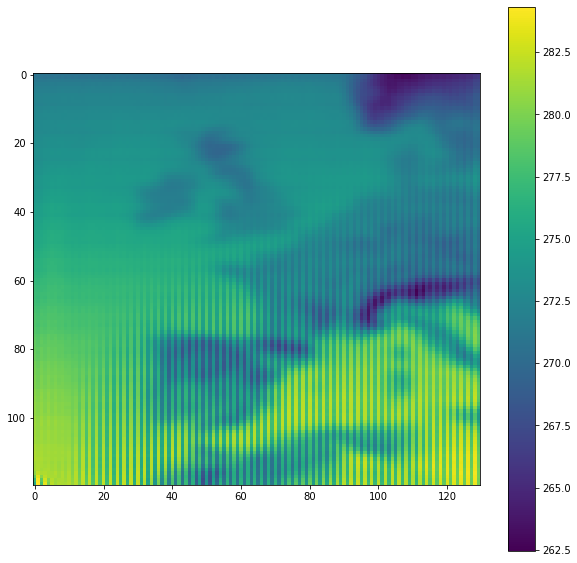

<IPython.core.display.Javascript object>

In [19]:
plt.figure(figsize=(10, 10))
plt.imshow(np.mean(train_preds_unpad[:, :, :, 0], axis=0))
cbar = plt.colorbar()

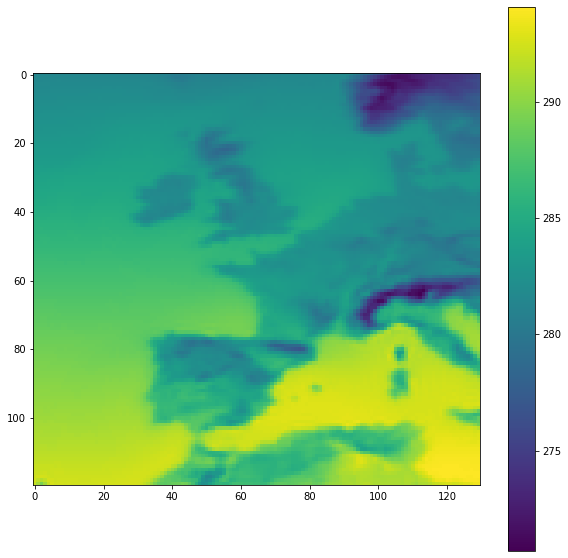

<IPython.core.display.Javascript object>

In [20]:
plt.figure(figsize=(10, 10))
plt.imshow(np.mean(unpadded_test_data_y[:, :, :], axis=0))
cbar = plt.colorbar()

#### Standard deviation

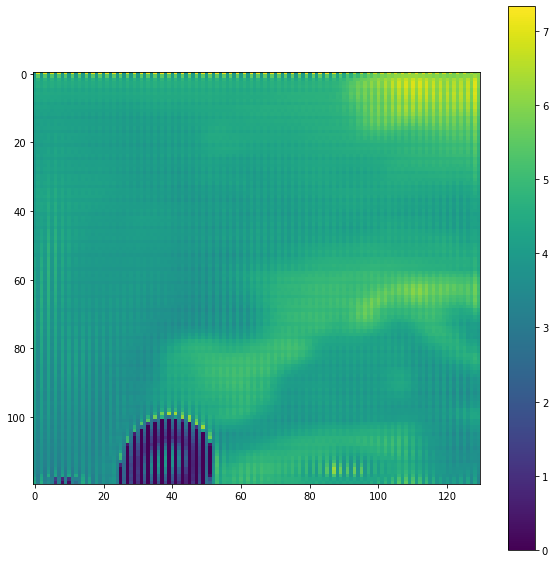

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(test_preds_unpad[0, :, :, 1])
cbar = plt.colorbar()

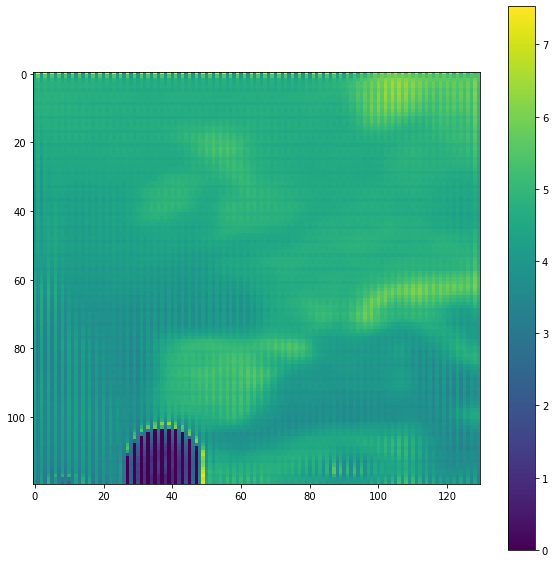

<IPython.core.display.Javascript object>

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(train_preds_unpad[0, :, :, 1])
cbar = plt.colorbar()

### 4. Model Evaluate

In [23]:
# With padded things
test_score = model.evaluate(
    [padded_test_data_mean, padded_test_data_std], padded_test_data_y, verbose=1
)

12/12 [==============================] - 2s 129ms/step - loss: 8.3509


<IPython.core.display.Javascript object>

In [24]:
test_score

8.350872993469238

<IPython.core.display.Javascript object>

In [25]:
# Without padds:
test_score_unpad = crps_normal(
    mu=test_preds_unpad[:, :, :, 0].flatten(),
    sigma=test_preds_unpad[:, :, :, 1].flatten(),
    y=unpadded_test_data_y.flatten(),
)

<IPython.core.display.Javascript object>

In [26]:
test_score_unpad.mean()

nan

<IPython.core.display.Javascript object>

In [27]:
test_preds_unpad[:, :, :, 1] = np.where(
    test_preds_unpad[:, :, :, 1] == 0, 0.000001, test_preds_unpad[:, :, :, 1]
)

<IPython.core.display.Javascript object>

In [28]:
# With padded things
train_score = model.evaluate(
    [padded_train_data_mean, padded_train_data_std], padded_train_data_y, verbose=1
)

train_score

45/45 [==============================] - 6s 141ms/step - loss: 8.1651


8.16507625579834

<IPython.core.display.Javascript object>